#  R&D Capital Replication


| Name | EID |
| --- | --- |
| Brandt Green | bwg537 |

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import statsmodels.formula.api as smf
import wrds
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data Sourcing
Data for this assignment comes from the following sources:

* Market Variables: [Ken French](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
  * Two data sets: One for daily returns and one for monthly.
* Split data: [CRSP Stock Events](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-events/distribution/)
* Security Return Data (Monthly): [CRSP Monthly](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/monthly-stock-file/)
* Security Return data (Daily): [CRSP Daily Stock](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-security-files/daily-stock-file/)

## Task 1: Analyzing Returns Around Stock Split Announcements


### Data Loading and Cleaning
First thing we need to do is load in our fama french data set of monthly returns:

In [24]:
french_df_daily = pd.read_csv('french.csv')

# Convert date to datetime and add new columns for year and month.
french_df_daily['date'] = pd.to_datetime(french_df_daily.date, format='%Y%m%d')
french_df_daily = french_df_daily.set_index('date')
# Convert the data from percents to decimal representation
french_df_daily = french_df_daily/100

# We'll need the market return to calculate excess return above the market for stock splits
french_df_daily['mkt'] = french_df_daily['Mkt-RF'] + french_df_daily['RF']

french_df_daily['year'] = french_df_daily.index.year
french_df_daily['month'] = french_df_daily.index.month
french_df_daily['day'] = french_df_daily.index.day

# Making this dataframe multi-indexed by year, month, and day which just makes working with the other return dataframes later on much easier
french_df_daily = french_df_daily.set_index(keys=['year','month','day']) 

french_df_daily

Mkt-RF      SMB      HML      RF      mkt
year month day                                            
1926 7     1    0.00100 -0.00230 -0.00280 0.00009  0.00109
           2    0.00450 -0.00340 -0.00030 0.00009  0.00459
           6    0.00170  0.00290 -0.00380 0.00009  0.00179
           7    0.00090 -0.00590  0.00000 0.00009  0.00099
           8    0.00210 -0.00380  0.00180 0.00009  0.00219
...                 ...      ...      ...     ...      ...
2021 10    25   0.00580  0.00490 -0.00160 0.00000  0.00580
           26   0.00040 -0.00710 -0.00320 0.00000  0.00040
           27  -0.00760 -0.00740 -0.01190 0.00000 -0.00760
           28   0.01140  0.00870 -0.00470 0.00000  0.01140
           29   0.00220  0.00190 -0.00820 0.00000  0.00220

[25105 rows x 5 columns]

Next, we need to grab the dataset that contains information for when stock splits occurred from WRDS. There are several noteworthy points here:
* The code for sharesplits is '5523' so we filter to only look for this code in our db query.
* We only care about stock splits from 6-months prior to 1980, so we also filter out older dates in the query.
* Last, we want to ignore reverse share splits, and stock dividends so we filter our dataframe to exclude entries where the share factor is less than 1.

In [25]:
# Need to have a connection open to the WRDS database
db = wrds.Connection(wrds_username='bgreen41')

# Write the query and request from the database. This returns the data as a pandas dataframe
query_string = f"""SELECT * from crsp.dsedist where distcd = 5523 and dclrdt > '1979-01-01'"""
split_data = db.raw_sql(query_string)

split_df = split_data[['permno','dclrdt','facshr','facpr']]

# Filter for where these two variables are equal because Eric said so.
split_df = split_df[split_df['facshr'] == split_df['facpr']]

# Reverse Stock splits will have a negative factor. We don't want those.
# Also, we don't want stock dividends, so we filter out anything where the facshr is less than one. This means we only have splits where the ratio is at least 2/1
split_df = split_df[split_df['facshr'] >= 1].copy()

# Make sure the date variable is a pd datetime, and also create the additional date related columns that will make things easy for us later
split_df['date'] = pd.to_datetime(split_df['dclrdt'])

split_df['year'] = split_df.date.dt.year
split_df['month'] = split_df.date.dt.month
split_df['day'] = split_df.date.dt.day

split_df.drop(columns=['dclrdt','facpr'],inplace=True)
split_df = split_df.sort_values('date')

split_df

Loading library list...
Done


,permno,facshr,date,year,month,day
114,10162.00000,1.00000,1979-01-04,1979,1,4
1033,12052.00000,1.50000,1979-01-04,1979,1,4
7251,63837.00000,1.00000,1979-01-19,1979,1,19
6443,60572.00000,1.00000,1979-01-26,1979,1,26
5022,49138.00000,1.00000,1979-01-26,1979,1,26
...,...,...,...,...,...,...
12326,88225.00000,3.00000,2020-11-06,2020,11,6
12509,89058.00000,1.00000,2020-11-06,2020,11,6
12806,90526.00000,1.00000,2020-11-06,2020,11,6
12913,91577.00000,1.00000,2020-11-06,2020,11,6


Here comes the fun. Because we want to figure out the returns around the day of the stock split, we need to download all of the daily returns for stocks since 1979. This raw data file is ridiculously large and miserable to work with because it has around 70 million rows. To lighten the load a bit, the below cell block goes through the process of cleaning that massive data file up a bit to hopefully shrink it down to a more manageable size. If this is the first time, the 'returns_data.csv' is being loaded, the cleaning code block will be executed, but otherwise we will just load in the already cleaned data. 

Post cleaning, our data set is now only 18 million rows.

In [26]:
import os

# If there is already a clean data file, skip all of this stuff and just load that. Otherwise we've got some cleaning to do!
if not os.path.exists('clean_returns.csv'):
    # CRSP Return Data. Big ole file
    return_data = pd.read_csv('returns_data.csv')

    # Only get return data for the companies we care about: the ones with splits
    return_df = return_data[return_data.PERMNO.isin(split_df.permno)]

    # Only filter for Common stock securities. 11,10 cat codes are for like 'normal' securities
    return_df = return_df[return_df.SHRCD.isin([11,10])] 

    # We only want share class 'A', which is common stocks only.
    # Also, we keep the NAs. 
    return_df = return_df[(return_df.SHRCLS == 'A') | (return_df.SHRCLS.isna())]

    # Filter out weird returns that have letters in them. I believe 'C' indicates it's the first data date
    return_df = return_df[~return_df.RET.astype(str).str.contains('[a-zA-Z]')]
    return_df.RET = return_df.RET.astype(float)

    return_df['date'] = pd.to_datetime(return_df['date'],format='%Y%m%d')
    return_df = return_df[return_df['date'].dt.year >= 1978]

    # Shares outstanding is originally expressed in 1000s. So we convert to dollars
    return_df['SHROUT'] = return_df['SHROUT'] * 1000

    # Convert any negative values in prc to positives. The negatives just indiciate that PRC is average of the bid ask spread instead of closing price.
    return_df['PRC'] = return_df['PRC'].abs()

    # Calculate Market cap
    return_df['market_cap'] = return_df.PRC * return_df.SHROUT

    # Add year, month, and day columns
    return_df['year'] = return_df['date'].dt.year
    return_df['month'] = return_df.date.dt.month
    return_df['day'] = return_df.date.dt.day


    return_df = return_df[['PERMNO','date','TICKER','RET','market_cap','year','month','day']]
    return_df.columns = [str(col).lower() for col in return_df.columns]

    return_df.to_csv('clean_returns.csv', index=False)

# Load in the clean file
return_df = pd.read_csv('clean_returns.csv')
# Make sure we've got datatime!
return_df['date'] = pd.to_datetime(return_df['date'])
return_df

,permno,date,ticker,ret,market_cap,year,month,day
0,10001,1986-01-10,GFGC,0.02174,5786875.00000,1986,1,10
1,10001,1986-01-13,GFGC,0.00000,5786875.00000,1986,1,13
2,10001,1986-01-14,GFGC,0.00000,5786875.00000,1986,1,14
3,10001,1986-01-15,GFGC,0.03191,5971562.50000,1986,1,15
4,10001,1986-01-16,GFGC,0.03093,6156250.00000,1986,1,16
...,...,...,...,...,...,...,...,...
18479508,93436,2020-12-24,TSLA,0.02444,627292463728.02002,2020,12,24
18479509,93436,2020-12-28,TSLA,0.00290,629112414690.00000,2020,12,28
18479510,93436,2020-12-29,TSLA,0.00347,631292577510.98999,2020,12,29
18479511,93436,2020-12-30,TSLA,0.04323,658582685217.03003,2020,12,30


Additionally, as one last data cleaning piece of the code, we filter our split dataframe to make sure that we are only looking at stocks that we have valid returns data for and that passed our screening criteria.

In [27]:
split_df = split_df[split_df.permno.isin(return_df.permno.unique())]

### Calculate Returns
We've got the data prepped, now it's time to examine the return profile of stocks after split announcements.

Below cell can take about 30-40 seconds to run.

In [28]:
"""Create a new dataframe with only return information, based on permno and index.
This may feel a little clunky, but it speeds up information lookup dramatically because now we can utilize df index lookups by permno and dates
instead of having to filter the 26 million dataframe everytime we want to lookup return info!
"""
master_returns_daily = pd.pivot_table(data=return_df,columns='permno',index=['year','month','day'],values='ret')
master_returns_daily

permno          10001  10009  10016  10020    10026    10032  10035  10046  \
year month day                                                               
1978 1     3      NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN   
           4      NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN   
           5      NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN   
           6      NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN   
           9      NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN   
...               ...    ...    ...    ...      ...      ...    ...    ...   
2020 12    24     NaN    NaN    NaN    NaN  0.00173  0.00270    NaN    NaN   
           28     NaN    NaN    NaN    NaN -0.00262  0.00693    NaN    NaN   
           29     NaN    NaN    NaN    NaN -0.01364 -0.01580    NaN    NaN   
           30     NaN    NaN    NaN    NaN  0.00058  0.00531    NaN    NaN   
           31     NaN    NaN    NaN    NaN  0.00791  0.00721    NaN    NaN   

permno          10056  10064  ...  93038  93060    93101  93105  93113  \
year month day                ...                                        
1978 1     3      NaN    NaN  ...    NaN    NaN      NaN    NaN    NaN   
           4      NaN    NaN  ...    NaN    NaN      NaN    NaN    NaN   
           5      NaN    NaN  ...    NaN    NaN      NaN    NaN    NaN   
           6      NaN    NaN  ...    NaN    NaN      NaN    NaN    NaN   
           9      NaN    NaN  ...    NaN    NaN      NaN    NaN    NaN   
...               ...    ...  ...    ...    ...      ...    ...    ...   
2020 12    24     NaN    NaN  ...    NaN    NaN -0.01266    NaN    NaN   
           28     NaN    NaN  ...    NaN    NaN -0.00400    NaN    NaN   
           29     NaN    NaN  ...    NaN    NaN -0.00245    NaN    NaN   
           30     NaN    NaN  ...    NaN    NaN  0.01045    NaN    NaN   
           31     NaN    NaN  ...    NaN    NaN -0.00910    NaN    NaN   

permno            93132    93312    93356    93423   93436  
year month day                                              
1978 1     3        NaN      NaN      NaN      NaN     NaN  
           4        NaN      NaN      NaN      NaN     NaN  
           5        NaN      NaN      NaN      NaN     NaN  
           6        NaN      NaN      NaN      NaN     NaN  
           9        NaN      NaN      NaN      NaN     NaN  
...                 ...      ...      ...      ...     ...  
2020 12    24  -0.00299  0.00294 -0.00316 -0.01146 0.02444  
           28  -0.00334  0.00962 -0.01813  0.00149 0.00290  
           29  -0.01179 -0.00677 -0.00046 -0.02582 0.00347  
           30   0.00332  0.00932  0.00674  0.04478 0.04323  
           31   0.00345  0.00262 -0.00376 -0.00583 0.01567  

[10845 rows x 3713 columns]

Below we create two helper functions to calculate the 2-day cumulative return of a security, given a permno and date information. Both functions will output the same number, but the first is a generic function and the second is meant to be used in conjunction with the dataframe.apply method of a pd df. The third serves the same purpose, but calculates the two day return of the market instead.

In [29]:
def get_two_day_return(permno, year, month, day) -> float:
    """Gets the two-day return of the day of the split and the day after."""
    # This would bug out if there was ever a split on the very last row of data we have in master_returns, but I don't think that is going to be an issue
    return (1+master_returns_daily.loc[(year,month,day):,permno][:2]).prod() - 1

def get_two_day_return_df(row:pd.Series) -> float:
    """Same as above, but for use on a pandas df"""
    return (1+master_returns_daily.loc[(row['year'], row['month'],row['day']):,row['permno']][:2]).prod() - 1 

def get_two_day_return_market(row:pd.Series) ->float:
    return (1+french_df_daily.loc[(row['year'], row['month'],row['day']):,'mkt'][:2]).prod() - 1 


Finally, we can actually calculate the returns of stock splits! We examine the two day return of a stock from the day of the announcement and the day after the announcement. 

In [30]:
split_results_df = split_df.copy()
split_results_df['two_day_return']= split_results_df.apply(get_two_day_return_df,axis=1)
split_results_df['two_day_mkt']= split_results_df.apply(get_two_day_return_market,axis=1)

# Calculate excess return of the stock over the market!
split_results_df['excess_over_market'] = split_results_df.two_day_return - split_results_df.two_day_mkt

The average for the two-day stock stock return upon split announcement is displayed. alongside the average excess of that return above the market:

In [31]:
pd.DataFrame(split_results_df[['two_day_return','excess_over_market']].mean())

,0
two_day_return,0.03237
excess_over_market,0.03142


## Task 2: Creating Stock Split Portfolios

### Load Data
So, this Looks like we are doing a lot of redundant data loading here since it will seem very similiar to the above data cleaning. The only real difference is that now we are working with pre-aggregated monthly data, which should help us process things quicker, cleaner, and with few errors!

In [32]:
french_df_monthly = pd.read_csv('french_monthly.csv')

# Convert date to datetime and add new columns for year and month.
french_df_monthly['date'] = pd.to_datetime(french_df_monthly.date,format='%Y%m')
french_df_monthly = french_df_monthly.set_index('date')
french_df_monthly['year'] = french_df_monthly.index.year
french_df_monthly['month'] = french_df_monthly.index.month

french_df_monthly['mkt'] = french_df_monthly['Mkt-RF'] + french_df_monthly['RF']

# Making this dataframe multi-indexed by year and month makes working with the other return dataframes later on much easier
french_df_monthly = french_df_monthly.set_index(keys=['year','month']) 

# Convert the data from percents to decimal representation
french_df_monthly = french_df_monthly/100 
french_df_monthly

Mkt-RF      SMB      HML      RF      mkt
year month                                            
1926 7      0.02960 -0.02380 -0.02730 0.00220  0.03180
     8      0.02640 -0.01470  0.04140 0.00250  0.02890
     9      0.00360 -0.01390  0.00120 0.00230  0.00590
     10    -0.03240 -0.00130  0.00650 0.00320 -0.02920
     11     0.02530 -0.00160 -0.00380 0.00310  0.02840
...             ...      ...      ...     ...      ...
2021 5      0.00290 -0.00280  0.07040 0.00000  0.00290
     6      0.02750  0.01800 -0.07760 0.00000  0.02750
     7      0.01270 -0.03960 -0.01750 0.00000  0.01270
     8      0.02900 -0.00480 -0.00130 0.00000  0.02900
     9     -0.04370  0.00800  0.05090 0.00000 -0.04370

[1143 rows x 5 columns]

There are some small differences here between this cleaning and the prior, but the results are identifical. We are mainly just filtering out securities that are not relevant.

In [33]:
crsp = pd.read_csv('crsp.csv')
crsp_cols_to_keep = ['PERMNO', 'date', 'SHRCD', 'TICKER', 'COMNAM', 'SHRCLS', 'PRC', 'RET', 'SHROUT']
return_df_m = crsp.copy()[crsp_cols_to_keep]

# Only get return data for the companies we care about: the ones with splits
return_df_m = return_df_m[return_df_m.PERMNO.isin(split_df.permno)]

return_df_m['date'] = pd.to_datetime(return_df_m['date'],format='%Y%m%d')
return_df_m = return_df_m[return_df_m['date'].dt.year >= 1978]

# Only filter for Common stock securities. 11,10 cat codes are for like 'normal' securities
return_df_m = return_df_m[return_df_m.SHRCD.isin([11,10])] 

# We only want share class 'A', which is common stocks only.
return_df_m = return_df_m[(return_df_m.SHRCLS == 'A') | (return_df_m.SHRCLS.isna())]

# Shares outstanding is originally expressed in 1000s. So we convert to dollars
return_df_m['SHROUT'] = return_df_m['SHROUT'] * 1000

# Convert any negative values in prc to positives. The negatives just indiciate that PRC is average of the bid ask spread instead of closing price.
return_df_m['PRC'] = return_df_m['PRC'].abs()

# Calculate Market cap
return_df_m['market_cap'] = return_df_m.PRC * return_df_m.SHROUT

# Filter out weird returns that have letters in them. I believe 'C' indicates it's the first data date
return_df_m = return_df_m[~return_df_m.RET.astype(str).str.contains('[a-zA-Z]')].copy() 
return_df_m.RET = return_df_m.RET.astype(float)

# Add year and month columns
return_df_m['year'] = return_df_m['date'].dt.year
return_df_m['month'] = return_df_m.date.dt.month

return_df_m = return_df_m.drop(columns=['SHRCD','SHRCLS','PRC','SHROUT','COMNAM','TICKER'])

return_df_m.columns = [str(col).lower() for col in return_df_m.columns]
return_df_m

,permno,date,ret,market_cap,year,month
21,10001,1986-02-28,0.02041,6156250.00000,1986,2
22,10001,1986-03-31,0.02520,6217812.50000,1986,3
23,10001,1986-04-30,0.00990,6279375.00000,1986,4
24,10001,1986-05-30,-0.00980,6217812.50000,1986,5
25,10001,1986-06-30,-0.01307,6033125.00000,1986,6
...,...,...,...,...,...,...
4118752,93436,2020-08-31,0.74145,464339070198.09003,2020,8
4118753,93436,2020-09-30,-0.13909,406701489480.00000,2020,9
4118754,93436,2020-10-30,-0.09550,367823513519.01001,2020,10
4118755,93436,2020-11-30,0.46274,538028588641.97998,2020,11


In [34]:
# Again, make sure that our split df only contains valid entries, where we have returns
split_df_port = split_df[split_df.permno.isin(return_df_m.permno.unique())].copy()

Again, calculate lookup tables for both returns and market caps. We'll need the market caps for each date to calculate the proper weights for value weighted portfolios.

In [35]:
master_returns_m = pd.pivot_table(data=return_df_m,columns='permno',index=['year','month'],values='ret')
market_caps = pd.pivot_table(data=return_df_m,columns='permno',index=['year','month'],values='market_cap')
market_caps

permno      10001  10009  10016  10020            10026            10032  \
year month                                                                 
1978 1        NaN    NaN    NaN    NaN              NaN              NaN   
     2        NaN    NaN    NaN    NaN              NaN              NaN   
     3        NaN    NaN    NaN    NaN              NaN              NaN   
     4        NaN    NaN    NaN    NaN              NaN              NaN   
     5        NaN    NaN    NaN    NaN              NaN              NaN   
...           ...    ...    ...    ...              ...              ...   
2020 8        NaN    NaN    NaN    NaN 2568775250.00000 2224743220.00000   
     9        NaN    NaN    NaN    NaN 2466326850.00000 2065644980.00000   
     10       NaN    NaN    NaN    NaN 2564306739.15000 2016799080.00000   
     11       NaN    NaN    NaN    NaN 2755722060.00000 2153366330.00000   
     12       NaN    NaN    NaN    NaN 2944882980.00000 2254246830.00000   

permno      10035  10046  10056  10064  ...  93038  93060            93101  \
year month                              ...                                  
1978 1        NaN    NaN    NaN    NaN  ...    NaN    NaN              NaN   
     2        NaN    NaN    NaN    NaN  ...    NaN    NaN              NaN   
     3        NaN    NaN    NaN    NaN  ...    NaN    NaN              NaN   
     4        NaN    NaN    NaN    NaN  ...    NaN    NaN              NaN   
     5        NaN    NaN    NaN    NaN  ...    NaN    NaN              NaN   
...           ...    ...    ...    ...  ...    ...    ...              ...   
2020 8        NaN    NaN    NaN    NaN  ...    NaN    NaN 6829419920.00000   
     9        NaN    NaN    NaN    NaN  ...    NaN    NaN 6536893200.00000   
     10       NaN    NaN    NaN    NaN  ...    NaN    NaN 7253311590.00000   
     11       NaN    NaN    NaN    NaN  ...    NaN    NaN 8582575050.00000   
     12       NaN    NaN    NaN    NaN  ...    NaN    NaN 9548002170.00000   

permno      93105  93113             93132             93312            93356  \
year month                                                                      
1978 1        NaN    NaN               NaN               NaN              NaN   
     2        NaN    NaN               NaN               NaN              NaN   
     3        NaN    NaN               NaN               NaN              NaN   
     4        NaN    NaN               NaN               NaN              NaN   
     5        NaN    NaN               NaN               NaN              NaN   
...           ...    ...               ...               ...              ...   
2020 8        NaN    NaN 21362633160.00000 16412997600.00000 2806024640.00000   
     9        NaN    NaN 19120563000.00000 15487068000.00000 2748188040.00000   
     10       NaN    NaN 17916582840.00000 15158247300.00000 3022097310.00000   
     11       NaN    NaN 20004172360.00000 17633428850.00000 3639298630.00000   
     12       NaN    NaN 24111171960.00000 18621453750.00000 3834204310.00000   

permno                93423              93436  
year month                                      
1978 1                  NaN                NaN  
     2                  NaN                NaN  
     3                  NaN                NaN  
     4                  NaN                NaN  
     5                  NaN                NaN  
...                     ...                ...  
2020 8     1841878260.00000 464339070198.09003  
     9     1720668600.00000 406701489480.00000  
     10    1837202740.00000 367823513519.01001  
     11    2611343210.00000 538028588641.97998  
     12    2897715700.00000 668905279711.97998  

[516 rows x 3713 columns]

### Share Split Portfolio Creation
The goal is to create a portfolio, consisting of only stocks that have split in the past 6 months, and is reconstituted monthly.

We start by creating a few helper functions that will be utilized during portfolio simulation/creation process. 

In [36]:
from dateutil.relativedelta import relativedelta


def get_previous_month_lookup(year, month) -> tuple:
    """Feels like a silly function, but we aften need a tuple containing the year and month numbers for the previous month."""
    if month == 1:
        return (year-1,12)
    else:
        return (year,month-1)

def get_biggest_500_stocks(date) ->list:
    """Send in a pandas datetime and it will return to you the 500 biggest stock permnos as of that date."""
    # We judge the biggest stocks by looking at the previous months market cap since this months market cap will not be know until 
    # the end of the month.
    lookup_index = get_previous_month_lookup(date.year, date.month)

    return market_caps.loc[lookup_index].sort_values()[:500].dropna().index.to_list()


def get_stocks_with_splits(date, exlude_top_500=False) -> list:
    """Return a list of all the permnos that had splits in the past 6 months. Optionally exculding the biggest 500 companies."""

    # Get the date 6-months ago and then filter our split_df to only include values within these dates.
    six_months_ago_date = date - relativedelta(months=6)
    filtered_df = split_df_port[(split_df_port['date'] < date) & (split_df['date'] >= six_months_ago_date)]

    if exlude_top_500:
        biggest_stocks = get_biggest_500_stocks(date)
        filtered_df = filtered_df[~filtered_df.permno.isin(biggest_stocks)]

    return list(filtered_df.permno.unique())


def calculate_port_return(permnos:list, year, month, method='equal_weight') -> float:
    """Send in a list of permnos along with the relevant year, month combo and this will calculate what the return is for that period."""

    # Only look at companies with actual returns in the month
    # This would only be relevant, if there was a permno in our portfolio  because it split in the last 6-months, but is not longer listed.
    # The below filter just makes sure we don't try to trade on securities that weren't listed in the period in question.
    valid_returns = master_returns_m.loc[(year,month)][permnos].dropna() 

    # Weights will be a series where the index is the permno and the values are the weights.
    # This setup is nice because it will allow for easy vector multipication with the master_returns_m data

    if method == 'equal_weight':
        stocks_in_port = len(valid_returns)
        # If there are no valid stocks to include in the portfolio, then just use an empty series!
        # I know it's clunky, but it works out. Otherwise, the below would divide by zero.
        if stocks_in_port > 0:
            weights = pd.Series(index=valid_returns.index, data=np.full(shape=len(valid_returns),fill_value=1/len(valid_returns)))
        else:
            weights = pd.Series()

    elif method == 'value_weight':
        # Get the market caps by using the end of previous month value, because that's what would be available on this trade date.
        cap_lookup_index = get_previous_month_lookup(year, month)
        # Filter market caps for valid permnos only
        valid_market_caps = market_caps.loc[cap_lookup_index][valid_returns.index] 

        # Market cap weights
        weights = valid_market_caps/valid_market_caps.sum() 
    
    # Calculate the weighted return which = portfolio return for this month.
    monthly_return = (weights * valid_returns).sum()

    return monthly_return


This is where the magic happens so its helpful to walk through the ideas:
1. Loop through each year within our sample period (1980-2020) and within each year, loop through each month.
2. At the beginning of each month, we will reconstitute and rebalance the portfolio. 
   1. The reconstition just means that we are reevaluating the portfolio constituents and including only those companies that have had stock splits within the past 6 months.
   2. The rebalancing also occurrs at this time. After, we calculate the stocks to include, we assign them weights. The rebalancing portion is actually sort of implicity in the code below, as it occurrs within the calcualte_port_returns function. 
3. We calculate the returns for each of our four portfolios and add this return calculation to our results_df which we can examine later.

In [37]:
port_names = ['value_weighted_all','equal_weighted_all','value_weighted_no_500','equal_weighted_no_500']

In [38]:
# Dataframe to store return results. It starts out as all NAs and then we will update the results as they are calculated below.
results_df = pd.DataFrame(index=master_returns_m.index,columns=port_names)

for year in range(1980,2021):

    for month in range(1,13):

        # We create a variable trade date, which is just the first day of each month, which just makes some of our filtering easier. 
        trade_date = pd.to_datetime(f'{year}-{month}-01') 

        # Get all of the permnos as a list for the stocks that have had splits in the past 6-months
        split_permnos = get_stocks_with_splits(trade_date)
        # Same as above, except now we exclude stocks that are also in the biggest 500 companies.
        split_permnos_no_500 = get_stocks_with_splits(trade_date,exlude_top_500=True)

        # Below, we calculate the returns that would have been generated for each portfolio for this month, based on the weighting scheme and stocks in the portfolio
        # Then add the return number to the results df.

        results_df.loc[(year,month), 'value_weighted_all'] = calculate_port_return(split_permnos, year,month,method='value_weight')
        results_df.loc[(year,month), 'equal_weighted_all'] = calculate_port_return(split_permnos, year,month,method='equal_weight')

        results_df.loc[(year,month), 'value_weighted_no_500'] = calculate_port_return(split_permnos_no_500, year,month,method='value_weight')
        results_df.loc[(year,month), 'equal_weighted_no_500'] = calculate_port_return(split_permnos_no_500, year,month,method='equal_weight')

# Drop na because when we originally created the results df, we created the index with more time periods than necessary
results_df = results_df.dropna()
results_df

value_weighted_all equal_weighted_all value_weighted_no_500  \
year month                                                               
1980 1                0.07965            0.17072               0.07739   
     2                0.12165           -0.01512               0.12239   
     3               -0.14812           -0.18558              -0.14799   
     4                0.05482            0.08871               0.05450   
     5                0.03790            0.07142               0.03771   
...                       ...                ...                   ...   
2020 8                0.21196            0.07578               0.21253   
     9               -0.10779           -0.07280              -0.10791   
     10              -0.06012           -0.03015              -0.06031   
     11               0.14667            0.14622               0.14661   
     12               0.13553            0.10998               0.13552   

           equal_weighted_no_500  
year month                        
1980 1                   0.10985  
     2                  -0.01714  
     3                  -0.18613  
     4                   0.08888  
     5                   0.07149  
...                          ...  
2020 8                   0.12800  
     9                  -0.08845  
     10                 -0.04965  
     11                  0.14033  
     12                  0.10387  

[492 rows x 4 columns]

Let's create a new dataframe consisting of the returns for each portfolio, but also add in the market variables we have downloaded from French. Once we have everything in one dataframe, running the regressions will be easy!

In [39]:
df = results_df.copy()

# Include Fama French Market Variables
df[['Mkt-RF','SMB','HML','RF']] = french_df_monthly[['Mkt-RF','SMB','HML','RF']]

# For CAPM/FF Purposes, we want to regress the excess returns. So right here we will just adjust our port returns by subtracting risk free return
df[port_names] = df[port_names].sub(df['RF'],axis=0)

# Not sure why the below is necessary, but the statsmodels regression formulas don't work without it.
df = df.astype(float)

In [40]:
stats_df = pd.DataFrame(columns=['CAPM_Betas','CAPM_Alpha','CAPM_t_stats', 'FamaFrench_Betas','FamaFrench_Alpha','FamaFrench_t_stats','Sharpe_Ratio'],index=port_names)

for port in port_names:
    capm_model = smf.ols(formula=f"{port} ~ Q('Mkt-RF')", data=df)
    capm_result = capm_model.fit()
    stats_df.loc[port,'CAPM_Alpha'] = capm_result.params['Intercept']
    stats_df.loc[port,'CAPM_t_stats'] = capm_result.tvalues.values.round(2)
    stats_df.loc[port,'CAPM_Betas'] = capm_result.params.values.round(2)


    ff_model = smf.ols(formula=f"{port} ~ Q('Mkt-RF') + SMB + HML", data=df)
    ff_result = ff_model.fit()
    stats_df.loc[port,'FamaFrench_Alpha'] = ff_result.params['Intercept']
    stats_df.loc[port,'FamaFrench_t_stats'] = ff_result.tvalues.values.round(2)
    stats_df.loc[port,'FamaFrench_Betas'] = ff_result.params.values.round(2)

    stats_df.loc[port,'Sharpe_Ratio'] = (df[port]).mean()/df[port].std()


stats_df[['CAPM_Alpha','FamaFrench_Alpha']] = stats_df[['CAPM_Alpha','FamaFrench_Alpha']]
stats_df

,CAPM_Betas,CAPM_Alpha,CAPM_t_stats,FamaFrench_Betas,FamaFrench_Alpha,FamaFrench_t_stats,Sharpe_Ratio
value_weighted_all,"[0.0, 1.09]",0.00343,"[1.77, 25.51]","[0.0, 1.0, 0.09, -0.46]",0.00464,"[2.52, 23.91, 1.45, -7.35]",0.17235
equal_weighted_all,"[0.01, 1.19]",0.00544,"[2.77, 27.6]","[0.01, 1.05, 0.62, -0.24]",0.00614,"[3.54, 26.6, 10.37, -4.12]",0.20256
value_weighted_no_500,"[0.0, 1.01]",0.00434,"[2.17, 23.11]","[0.01, 0.92, 0.05, -0.61]",0.00593,"[3.25, 21.99, 0.72, -9.88]",0.18283
equal_weighted_no_500,"[0.01, 1.12]",0.00638,"[3.04, 24.27]","[0.01, 0.95, 0.52, -0.55]",0.00786,"[4.37, 23.25, 8.44, -9.0]",0.21026


In [1]:
.00343*12

0.04116

## Graphical Appendix

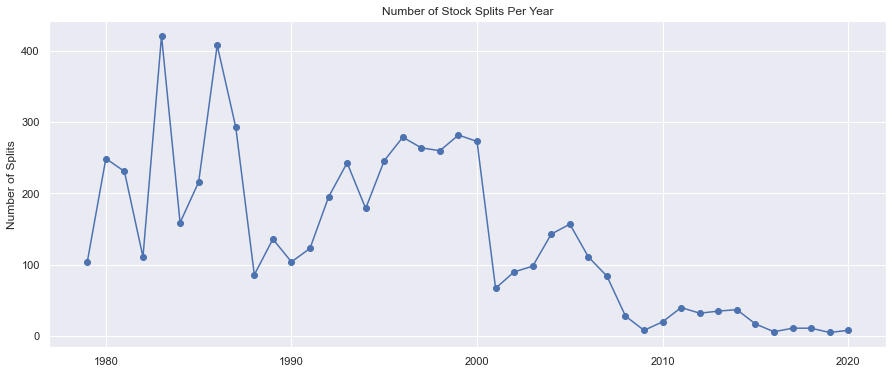

In [41]:
split_df_port.year.value_counts().sort_index().plot(figsize=(15,6),marker='o')
plt.title('Number of Stock Splits Per Year')
plt.ylabel('Number of Splits');

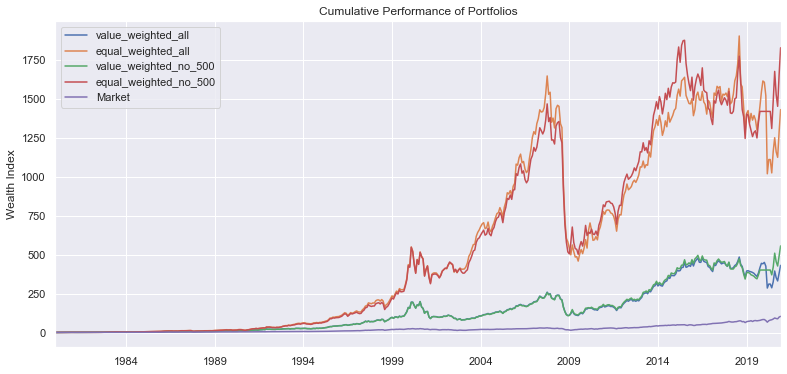

In [42]:
datetime_index = pd.to_datetime([f'{year}-{month}-01' for year, month in results_df.index])
df_plot = results_df.copy()
df_plot['Market'] = french_df_monthly.mkt
df_plot.index = datetime_index
(1+df_plot).cumprod().plot(figsize=(13,6))
plt.title('Cumulative Performance of Portfolios')
plt.ylabel('Wealth Index');

In [43]:
stats = df_plot.aggregate(['mean','std'])
stats = stats.T
stats['mean'] = stats['mean']*12
stats['std'] = stats['std']*12**.5

stats

,mean,std
value_weighted_all,0.17467,0.22478
equal_weighted_all,0.20755,0.23845
value_weighted_no_500,0.17930,0.21918
equal_weighted_no_500,0.21268,0.23672
Market,0.12618,0.15586
